# Sesión 5 - Implementación de algoritmos DQN y PG

> En la presente sesión, se va a desarrollar la **implementación** de los algoritmos básicos de aprendizaje por refuerzo: **Deep Q-networks (DQN)**, y **Policy Gradients (PG)**. El caso de uso desarrollado consistirá en el **Atary**, cuyo **entorno** es modelado por la librería de acceso público de **OpenAI gym**. Se hará uso de dos librería para la implementación de algoritmos de aprendizaje por refuerzo: **keras-rl** y **pytorch**. La primera, de más alto nivel, servirá para establecer un conocimiento práctico de los métodos DQN, y analizar los distintos hiperparámetros de entrenamiento. En el segundo caso, PG será implemetado con pytorch, librería de más bajo nivel, y la cuál permitirá trabajar en detalle la estrategia de aprendizaje on-policy y la optimización por gradiente de la policy.






---
## **PARTE 1** - Instalación y requisitos previos

> Las prácticas han sido preparadas para poder realizarse en el entorno de trabajo de Google Colab. Sin embargo, esta plataforma presenta ciertas incompatibilidades a la hora de visualizar la renderización en gym. Por ello, para obtener estas visualizaciones, se deberá trasladar el entorno de trabajo a local. Por ello, el presente dosier presenta instrucciones para poder trabajar en ambos entornos. Siga los siguientes pasos para un correcto funcionamiento:
1.   **LOCAL:** Preparar el enviroment, siguiendo las intrucciones detalladas en la sección *1.1.Preparar enviroment*.
2.  **AMBOS:** Modificar las variables "mount" y "drive_mount" a la carpeta de trabajo en drive en el caso de estar en Colab, y ejecturar la celda *1.2.Localizar entorno de trabajo*.
3. **COLAB:** se deberá ejecutar las celdas correspondientes al montaje de la carpeta de trabajo en Drive. Esta corresponde a la sección *1.3.Montar carpeta de datos local*.
4.  **AMBOS:** Instalar las librerías necesarias, siguiendo la sección *1.4.Instalar librerías necesarias*.



---
### 1.1. Preparar enviroment (solo local)



> Para preparar el entorno de trabajo en local, se han seguido los siguientes pasos:
1. En Windows, puede ser necesario instalar las C++ Build Tools. Para ello, siga los siguientes pasos: https://towardsdatascience.com/how-to-install-openai-gym-in-a-windows-environment-338969e24d30.
2. Instalar Anaconda
3. Siguiendo el código que se presenta comentado en la próxima celda: Crear un enviroment, cambiar la ruta de trabajo, e instalar librerías básicas.


```
conda update --all
conda create --name miar_rl python=3.8
conda activate miar_rl
cd "PATH_TO_FOLDER"
conda install git
pip install jupyter
```


4. Abrir la notebook con *jupyter-notebook*.



```
jupyter-notebook
```




---
### 1.2. Localizar entorno de trabajo: Google colab o local

In [5]:
# ATENCIÓN!! Modificar ruta relativa a la práctica si es distinta (drive_root)
mount='/content/gdrive'
drive_root = mount + "/My Drive/08_MIAR/sesiones_practicas/sesion_practica_1"

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

---
### 1.3. Montar carpeta de datos local (solo Colab)

In [2]:
# Switch to the directory on the Google Drive that you want to use
import os
if IN_COLAB:
  print("We're running Colab")

  if IN_COLAB:
    # Mount the Google Drive at mount
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
      print("\nColab: making sure ", drive_root, " exists.")
      os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
# Verify we're in the correct working directory
%pwd
print("Archivos en el directorio: ")
print(os.listdir())

Archivos en el directorio: 
['.ipynb_checkpoints', '08MIAR_dqn_pg.ipynb', 'dqn_BreakoutDeterministic-v4_weights_1750000.h5f.data-00000-of-00001', 'dqn_BreakoutDeterministic-v4_weights_1750000.h5f.index', 'images']


---
### 1.4. Instalar librerías necesarias


In [ ]:
if IN_COLAB:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install keras-rl2==1.0.5
  %pip install tensorflow==2.8
else:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install pyglet==1.5.0
  %pip install h5py==3.1.0
  %pip install Pillow==9.5.0
  %pip install keras-rl2==1.0.5
  %pip install Keras==2.2.4
  %pip install tensorflow==2.5.3
  %pip install torch==2.0.1
  %pip install agents==1.4.0

---
### 1.5.Acerca de las librerías para RL

Librería para trabajar con nuestros entornos: gym (https://gym.openai.com/) \
Librería para trabajar con deep learning: tensorflow (https://www.tensorflow.org/) \
Librería para desarrollar soluciones de RL a alto nivel: keras-rl (https://github.com/keras-rl/keras-rl) \


---
## **PARTE 2** - *Deep Q-learning*


---
### 2.1. DQN Pseudo-código

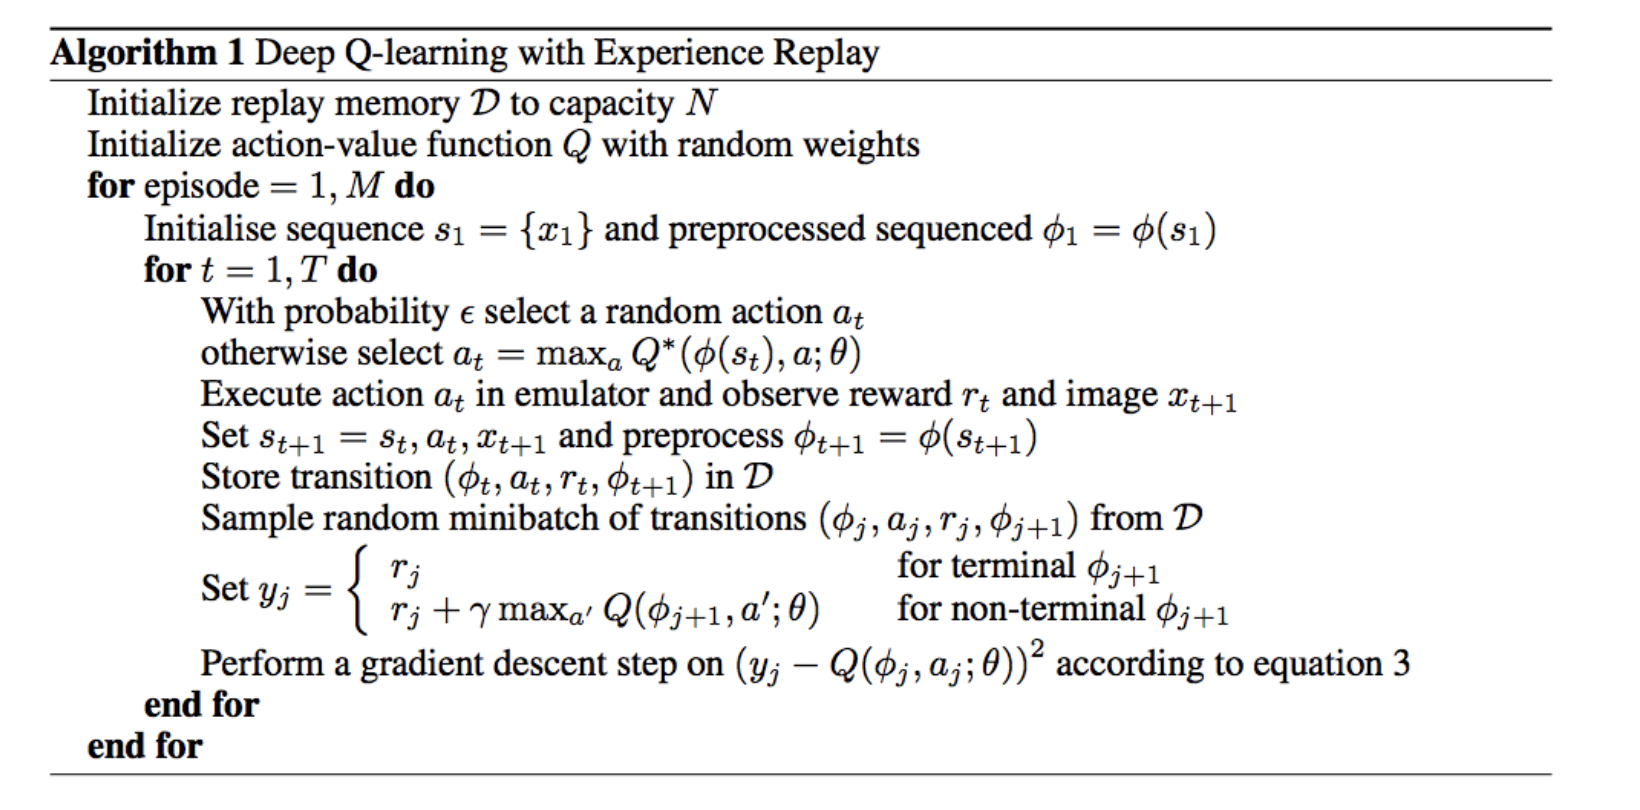

In [3]:
from IPython import display
display.Image("images/dqn.png", width = 600, height = 300)

---
### 2.2. Ejemplo de DQN with keras-rl - CartPole

¿Quieres intentar estabilizar el péndulo invertido tu?
https://jeffjar.me/cartpole.html

Información del entorno:
https://www.gymlibrary.dev/environments/classic_control/cart_pole/

Basado en: https://github.com/keras-rl/keras-rl/blob/master/examples/dqn_cartpole.py

In [2]:
import numpy as np
import gym

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [5]:
ENV_NAME = 'CartPole-v0'

# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [6]:
print("Numero de acciones disponibles:" + str(nb_actions))

Numero de acciones disponibles:2


In [7]:
print("Formato de las observaciones:")
env.observation_space

Formato de las observaciones:


Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)

In [ ]:
# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

In [ ]:
# Let's define the memory for storing the experience
memory = SequentialMemory(limit=50000, window_length=1)

In [ ]:
# Define the policy that our agent will follow
policy = BoltzmannQPolicy()

In [ ]:
# Define the agent
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory,
               nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

In [ ]:
# Train the agent
dqn.fit(env, nb_steps=50000, visualize=False, verbose=2)

# After training is done, we save the final weights.
dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

In [ ]:
# Finally, evaluate our algorithm for 5 episodes.
dqn.load_weights('dqn_{}_weights.h5f'.format(ENV_NAME))
dqn.test(env, nb_episodes=10, visualize=False)


---
### 2.3. Ejemplo DQN con Keras-rl - Breakout

Información del entorno: https://www.gymlibrary.dev/environments/atari/breakout/

Basado en: https://github.com/Finspire13/pytorch-policy-gradient-example/blob/master/pg.py

In [3]:
from __future__ import division

from PIL import Image
import numpy as np
import gym

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

In [4]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

In [5]:
# In this example, we need to preprocess the observations
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

In [6]:
# Get the environment and extract the number of actions.
import gym
import numpy as np
env_name = 'BreakoutDeterministic-v4'
env = gym.make(env_name)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [7]:
print("Numero de acciones disponibles: " + str(nb_actions))

Numero de acciones disponibles: 4


In [8]:
print("Formato de las observaciones:")
env.observation_space

Formato de las observaciones:


Box(0, 255, (210, 160, 3), uint8)

In [9]:
# Next, we build our model. We use the same model that was described by Mnih et al. (2015).
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE
model = Sequential()
print(K.image_data_format())
if K.image_data_format() == 'channels_last':
    # (width, height, channels)
    model.add(Permute((2, 3, 1), input_shape=input_shape))
elif K.image_data_format() == 'channels_first':
    # (channels, width, height)
    model.add(Permute((1, 2, 3), input_shape=input_shape))
else:
    raise RuntimeError('Unknown image_dim_ordering.')

model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

channels_last
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute (Permute)            (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 32)        8224      
_________________________________________________________________
activation (Activation)      (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
activation_1 (Activation)    (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
activation_2 (Activation)    (None, 7, 7, 

In [10]:
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
processor = AtariProcessor()

In [11]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)

In [12]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy,
               memory=memory, processor=processor,
               nb_steps_warmup=50000, gamma=.99,
               target_model_update=10000,
               train_interval=4)
dqn.compile(Adam(learning_rate=.00025), metrics=['mae'])

In [ ]:
# Training part
weights_filename = 'dqn_{}_weights.h5f'.format(env_name)
checkpoint_weights_filename = 'dqn_' + env_name + '_weights_{step}.h5f'
log_filename = 'dqn_{}_log.json'.format(env_name)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileLogger(log_filename, interval=100)]

dqn.fit(env, callbacks=callbacks, nb_steps=1750000, log_interval=10000, visualize=False)

dqn.save_weights(weights_filename, overwrite=True)

In [ ]:
# Testing part
#weights_filename = 'dqn_{}_weights.h5f'.format(env_name)
weights_filename = "dqn_BreakoutDeterministic-v4_weights_1750000.h5f"
dqn.load_weights(weights_filename)
dqn.test(env, nb_episodes=20, visualize=True)

Testing for 20 episodes ...


C:\Users\jusir\anaconda3\envs\miar_rl\lib\site-packages\tensorflow\python\keras\engine\training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Episode 1: reward: 35.000, steps: 1248
Episode 2: reward: 35.000, steps: 1248
Episode 3: reward: 35.000, steps: 1248
Episode 4: reward: 35.000, steps: 1248
Episode 5: reward: 35.000, steps: 1248
Episode 6: reward: 35.000, steps: 1248
Episode 7: reward: 35.000, steps: 1248
Episode 8: reward: 35.000, steps: 1248


---
## **PARTE 3** - *Policy Gradients*


---
### 3.1. PG Pseudo-código

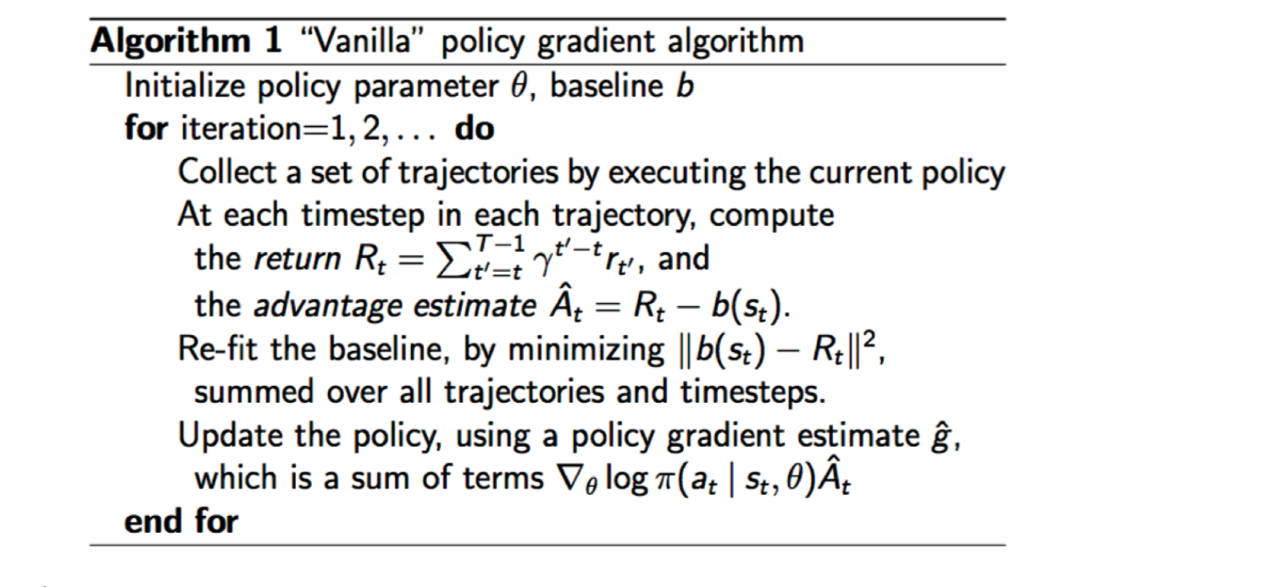

In [ ]:
from IPython import display
display.Image("images/pg.png", width = 600, height = 300)

- En el paso de "Collect a set of trajectories" hay un bucle while implícito donde se recopilan un conjunto trayectorias, todas las tuplas de experiencia (s,a,r,s')
- $R_t - b(s_t)$ : $b(s_t)$ es el baseline (valor medio de todas las recompensas), esto es para intentar reescalar la recompensa para evitar valores grandes en los gradientes

---
### 3.2. Ejemplo de *Policy Gradient* con *Pytorch*

Información del entorno: https://www.gymlibrary.dev/environments/atari/breakout/

Basado en: https://github.com/keras-rl/keras-rl/blob/master/examples/dqn_atari.py

In [1]:
import numpy as np
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.distributions import Bernoulli
from torch.autograd import Variable
from itertools import count

In [2]:
# Define the model for our agent policy
class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()

        self.fc1 = nn.Linear(4, 24) # fully connected (Dense)
        self.fc2 = nn.Linear(24, 36)
        self.fc3 = nn.Linear(36, 1)

    def forward(self, x): # x vector de características
        x = F.relu(self.fc1(x)) # aplica una función de activación tipo relu a la salida de la FC(Dense) 1
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x)) # sigmoide a la salida, pero puede ser softmax

        return x

In [3]:
# Plot duration curve - learning curve
episode_durations = [] # se puede utilizar como métrica para saber cuánto aguanta el modelo (cuán bueno es), en este caso más tiempo = mejor

# Parameters
num_episode = 5000
batch_size = 5 # Una vez hemos recopilado trayectorias con qué tamaño de batch entrenamos / Trayectorias recopiladas antes de entrenar
learning_rate = 0.01
gamma = 0.99

env = gym.make('CartPole-v0')
policy_net = PolicyNet()#.to("cuda")#.to("cpu")
optimizer = torch.optim.RMSprop(policy_net.parameters(), lr=learning_rate)

# Batch History - Experience, transiciones
state_pool = []
action_pool = []
reward_pool = []
steps = 0

In [ ]:
for e in range(num_episode): # episodios
    state = env.reset() # reseteamos el entorno
    state = torch.from_numpy(state).float()
    state = Variable(state)#.to("cuda")#.to("cpu") # pasamos de np.array a tensor de pytorch
    if not IN_COLAB:
      env.render(mode='rgb_array')

    for t in count(): # iteraciones, se podría añadir una T para que no fuera infinito
        # Select the action following a probability distribution
        probs = policy_net(state)
        m = Bernoulli(probs)
        action = m.sample()

        action = action.data.numpy().astype(int)[0] # tensor de pyorch a np.array, y seleccionamos una acción

        next_state, reward, done, _ = env.step(action)
        if not IN_COLAB:
          env.render(mode='rgb_array')

        # To mark boundaries between episodes
        if done:
            reward = 0

        # Almacenamos la experiencia
        state_pool.append(state)
        action_pool.append(float(action))
        reward_pool.append(reward)

        # Pasamos el s' a s
        state = next_state
        state = torch.from_numpy(state).float()
        state = Variable(state)

        steps += 1

        if done:
            # almacenamos la duración del episodio
            episode_durations.append(t + 1)
            print("Episode duration: ",t)
            break

    # Update policy
    if e > 0 and e % batch_size == 0:

        # Discount reward
        running_add = 0
        for i in reversed(range(steps)): # de T a 0, desde el final hasta el pricipio
            # empezamos con running_add = 0 * el discount reward + la última recompensa esperada a futuro
            running_add = running_add * gamma + reward_pool[i]
            # guardamos esa recompensa esperada a futuro (los discount reward factors) en una lista
            reward_pool[i] = running_add

        # Normalize reward
        reward_mean = np.mean(reward_pool)
        reward_std = np.std(reward_pool)
        for i in range(steps):
            reward_pool[i] = (reward_pool[i] - reward_mean) / reward_std

        # Gradient Descent
        optimizer.zero_grad()

        for i in range(steps):
            state = state_pool[i]
            action = Variable(torch.FloatTensor([action_pool[i]]))
            reward = reward_pool[i]

            probs = policy_net(state) # forward con ese estado
            m = Bernoulli(probs)
            loss = -m.log_prob(action) * reward  # Negative score function x reward
            loss.backward() # calculamos los gradientes, aún no actualizamos los pesos, acumulamos gradientes

        optimizer.step() # se aplican los gradientes sobre los pesos, se actualizan

        # se vacía la memoria
        state_pool = []
        action_pool = []
        reward_pool = []
        steps = 0

---

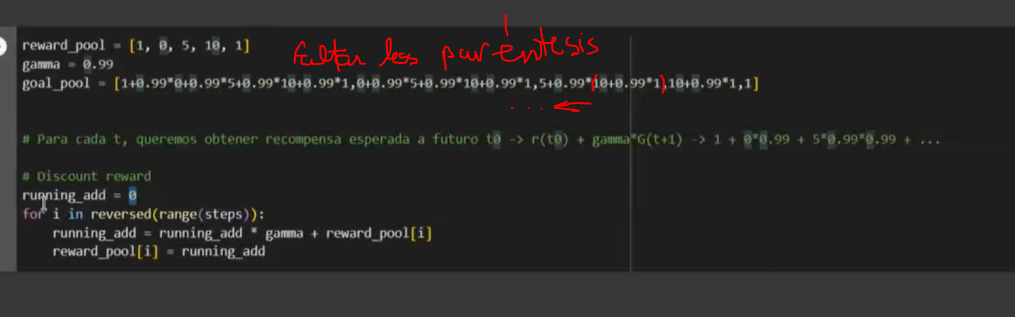